<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/alpaca_LightGBM_execution_adapter_v3.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install alpaca-trade-api
!pip install alpaca-trade-api python-dotenv ta
!pip install -q alpaca-trade-api python-dotenv ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.7/757.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 9.1 MB/s eta 0:00:00
  Created wheel for msgpack: filename=msgpack-1.0.3-cp311-cp311-linux_x86_64.whl size=15688 sha256=88f5cc7632ef3fe9c8f9d01edf0739b17b1d40248792dcb24a4a90a33d814d55
  Stored in directory: /root/.cache/pip/wheels/f6/35/da/ed9b26b510235e00e3a3c3bab7bad97b59214729662255ab3d
Successfully built msgpack
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.1.1
    Uninstalling msgpack-1.1.1:
      Successfully uninstalled msgpack-1.1.1
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling

In [2]:
import os
import pickle
import csv
import pandas as pd
import lightgbm as lgb
import ta
import numpy as np
import warnings
import matplotlib.pyplot as plt  # For plotting equity
from datetime import datetime, timedelta
from dotenv import load_dotenv
from alpaca_trade_api.rest import REST, TimeFrame, APIError

warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

RESULTS_DIR = "/content/drive/MyDrive/Alpaca_Results/LightGBM"
os.makedirs(RESULTS_DIR, exist_ok=True)

Mounted at /content/drive


In [3]:
from google.colab import files
uploaded = files.upload()  # Prompts you to upload the .env file for the key

Saving Alpaca_keys.env.txt to Alpaca_keys.env.txt


In [4]:
import os

# Rename to .env so dotenv can recognize it
os.rename("Alpaca_keys.env.txt", ".env")

In [5]:
from google.colab import files
uploaded = files.upload()  # Upload: model_ABT.txt, features_ABT.txt, scaler_ABT.pkl

import lightgbm as lgb
import pickle

# Load LightGBM model
model = lgb.Booster(model_file='model_ABT.txt')

# Load feature list
with open('features_ABT.txt', 'r') as f:
    model_features = f.read().strip().split(',')


# Load scaler
with open('scaler_ABT.pkl', 'rb') as f:
    scaler = pickle.load(f)

print("Model, features, and scaler loaded for ABT.")


Saving features_ABT.txt to features_ABT.txt
Saving features_BRK.B.txt to features_BRK.B.txt
Saving features_MDT.txt to features_MDT.txt
Saving features_PG.txt to features_PG.txt
Saving features_PM.txt to features_PM.txt
Saving model_ABT.txt to model_ABT.txt
Saving model_BRK.B.txt to model_BRK.B.txt
Saving model_MDT.txt to model_MDT.txt
Saving model_PG.txt to model_PG.txt
Saving model_PM.txt to model_PM.txt
Saving scaler_ABT.pkl to scaler_ABT.pkl
Saving scaler_BRK.B.pkl to scaler_BRK.B.pkl
Saving scaler_MDT.pkl to scaler_MDT.pkl
Saving scaler_PG.pkl to scaler_PG.pkl
Saving scaler_PM.pkl to scaler_PM.pkl
Model, features, and scaler loaded for ABT.


In [7]:
# Load .env credentials
load_dotenv(override=True)
API_KEY = os.getenv("APCA_API_KEY_ID")
SECRET_KEY = os.getenv("APCA_API_SECRET_KEY")
BASE_URL = "https://paper-api.alpaca.markets"  # or live URL

# Create API object
api = REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

# Check account
account = api.get_account()
print("Account status:", account.status)

Account status: ACTIVE


In [8]:
#Load Model, Scaler, Features Dynamically
def load_model_artifacts(ticker):
    model = lgb.Booster(model_file=f'model_{ticker}.txt')
    with open(f'features_{ticker}.txt', 'r') as f:
        features = f.read().strip().split(',')
    with open(f'scaler_{ticker}.pkl', 'rb') as f:
        scaler = pickle.load(f)
    return model, features, scaler

In [9]:
def add_features(df):
    """Add engineered technical features to the DataFrame."""
    df['SMA_50'] = ta.trend.sma_indicator(df['close'], window=50)
    df['EMA_20'] = ta.trend.ema_indicator(df['close'], window=20)
    volatility = df['close'].rolling(14).std()
    rsi = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    macd = ta.trend.macd_diff(df['close'])
    signal_line = ta.trend.macd_signal(df['close'])
    df['RSI_voladj'] = rsi * volatility
    df['MACD_voladj'] = macd * volatility
    df['Signal_Line'] = signal_line
    df['ATR_voladj'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range() * volatility
    df['OBV'] = ta.volume.on_balance_volume(df['close'], df['volume'])
    df['CCI_voladj'] = ta.trend.cci(df['high'], df['low'], df['close'], window=20) * volatility
    return df.dropna()

In [10]:
def log_trade(ticker, signal, action, price, equity, position_qty, confidence=None):
    log_file = os.path.join(RESULTS_DIR, f"trade_log_{ticker}.csv")
    log_data = {
        'datetime': [datetime.utcnow()],
        'ticker': [ticker],
        'signal': [signal],
        'action': [action],
        'price': [price],
        'equity': [equity],
        'position_qty': [position_qty],
        'confidence': [confidence],
        'reason': [f"Signal={signal}, Action={action}, PositionHeld={position_qty > 0}"]
    }
    log_df = pd.DataFrame(log_data)
    if os.path.exists(log_file):
        log_df.to_csv(log_file, mode='a', header=False, index=False)
    else:
        log_df.to_csv(log_file, index=False)
    print(f"Logged trade to Drive: {log_file}")



Running strategy for ABT...
 Model for ABT does not support predict_proba — likely not a classifier.

Running strategy for BRK.B...
 Model for BRK.B does not support predict_proba — likely not a classifier.

Running strategy for PM...
 Model for PM does not support predict_proba — likely not a classifier.

Running strategy for PG...
 Model for PG does not support predict_proba — likely not a classifier.

Running strategy for MDT...
 Model for MDT does not support predict_proba — likely not a classifier.

Final Portfolio:
AAPL: 2 shares ($422.66)
ABT: 1 shares ($128.01)
BRK.B: 1 shares ($475.9)
MDT: 1 shares ($92.44)
PG: 1 shares ($156.8)
PM: 1 shares ($162.75)


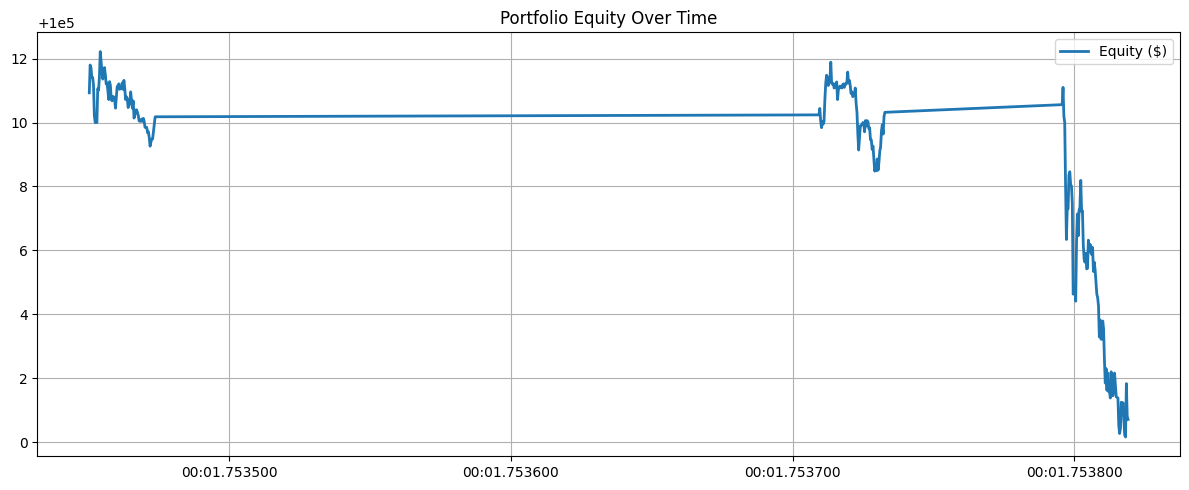

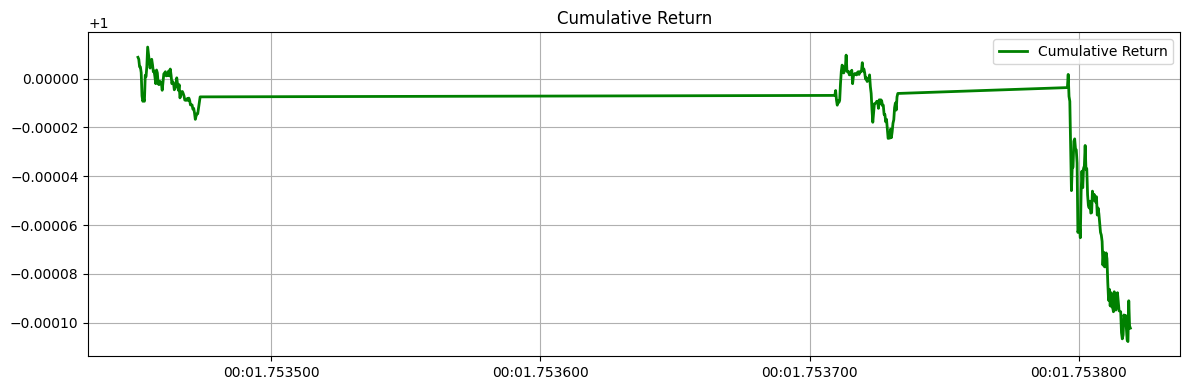


Trade Summary:
ABT: {'Initial_Buy': 1}


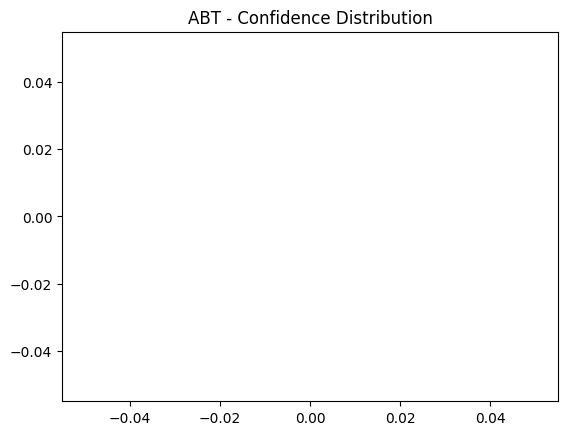

BRK.B: {'Initial_Buy': 1}


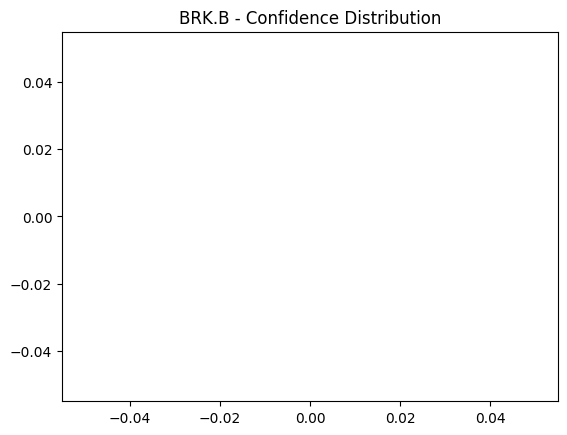

PM: {'Initial_Buy': 1}


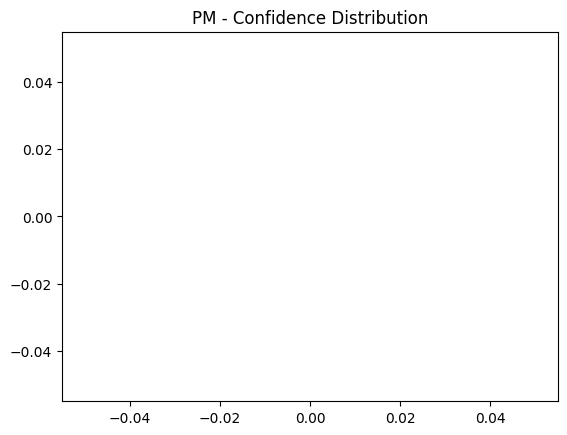

PG: {'Initial_Buy': 1}


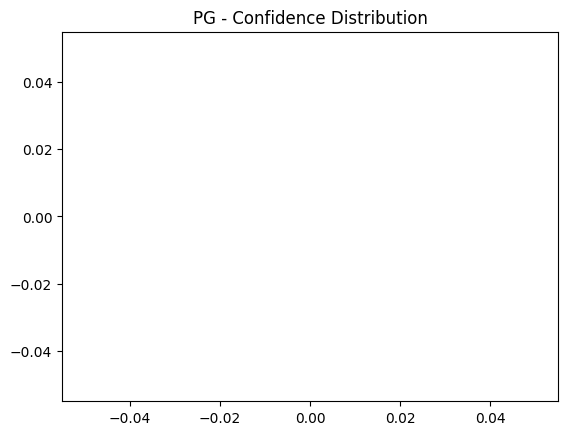

MDT: {'Initial_Buy': 1}


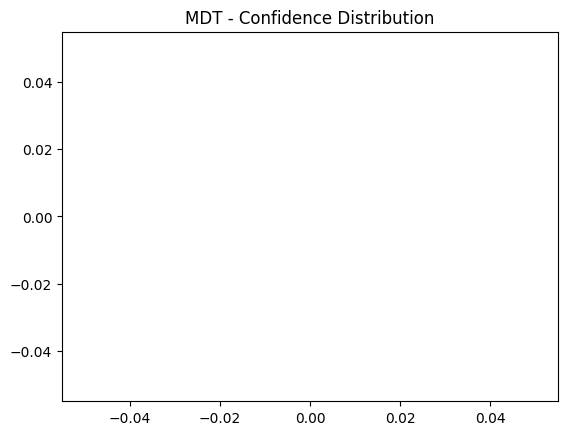

In [11]:
# === Imports ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from alpaca_trade_api.rest import REST, TimeFrame, APIError

# === Alpaca API Keys ===
API_KEY = os.getenv("APCA_API_KEY_ID")
API_SECRET = os.getenv("APCA_API_SECRET_KEY")
BASE_URL = "https://paper-api.alpaca.markets"
api = REST(API_KEY, API_SECRET, BASE_URL)

# === Utility Functions ===
def safe_get_filled_price(api, order_id, fallback_price=None):
    try:
        filled = api.get_order(order_id)
        return float(filled.filled_avg_price) if filled.filled_avg_price else fallback_price
    except Exception as e:
        print(f"Could not get filled price: {e}")
        return fallback_price

def safe_get_equity(api, period="1D", timeframe="5Min"):
    try:
        return api.get_portfolio_history(period=period, timeframe=timeframe).equity[-1]
    except Exception as e:
        print(f"Could not get equity: {e}")
        return None

def log_trade(ticker, signal, action, price, equity, position_qty, confidence=None):
    log_file = os.path.join(RESULTS_DIR, f"trade_log_{ticker}.csv")
    row = {
        'datetime': datetime.utcnow(),
        'ticker': ticker,
        'signal': signal,
        'action': action,
        'price': price,
        'equity': equity,
        'position_qty': position_qty,
        'confidence': confidence,
        'reason': f"Signal={signal}, Action={action}, Position={position_qty > 0}"
    }
    df = pd.DataFrame([row])
    if os.path.exists(log_file):
        df.to_csv(log_file, mode='a', header=False, index=False)
    else:
        df.to_csv(log_file, index=False)
    print(f"Logged trade to Drive: {log_file}")

# === Config ===
COOLDOWN_MINUTES = 60
STOP_LOSS = 0.03
TAKE_PROFIT = 0.05
RESULTS_DIR = "/content/drive/MyDrive/Alpaca_Results/LightGBM"
tickers = ["ABT", "BRK.B", "PM", "PG", "MDT"]

# === Main Strategy ===
for ticker in tickers:
    print(f"\nRunning strategy for {ticker}...")

    try:
        model, model_features, scaler = load_model_artifacts(ticker)
    except Exception as e:
        print(f"Load error: {e}")
        continue
    if not hasattr(model, "predict_proba"):
        print(f"Model for {ticker} does not support predict_proba — likely not a classifier.")
        continue

    try:
        end = datetime.utcnow().replace(microsecond=0).isoformat() + "Z"
        start = (datetime.utcnow() - timedelta(days=45)).replace(microsecond=0).isoformat() + "Z"
        bars = api.get_bars(ticker, TimeFrame.Hour, start=start, end=end, feed="iex").df.reset_index()
        bars = add_features(bars)
        if len(bars) < 10:
            print(f"Not enough data for {ticker}")
            continue
    except Exception as e:
        print(f"Data fetch error: {e}")
        continue

    if not all(f in bars.columns for f in model_features):
        print(f"Missing features: {[f for f in model_features if f not in bars.columns]}")
        continue

    X_live = bars[model_features].copy()
    X_live.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_live.dropna(inplace=True)
    X_scaled = scaler.transform(X_live)
    signal = int(model.predict(X_scaled)[-1])

    try:
        probas = model.predict_proba(X_scaled)
        confidence = np.max(probas[-1])
        print(f"Signal: {signal} | Confidence: {confidence:.2%}")
    except:
        confidence = None
        print(f"Signal: {signal} (No probas)")

    price = bars.iloc[-1]['close']
    equity = safe_get_equity(api)
    action = "Hold"
    position_qty = 0

    try:
        clock = api.get_clock()
        if not clock.is_open:
            print("Market closed.")
            continue

        try:
            pos = api.get_position(ticker)
            has_position = float(pos.qty) > 0
            position_qty = float(pos.qty)
        except APIError:
            has_position = False
            print(f"No open position in {ticker}")

        # === Stop Loss / Take Profit ===
        if has_position:
            entry_price = float(pos.avg_entry_price)
            unrealized_pct = (price - entry_price) / entry_price
            print(f"Unrealized %: {unrealized_pct:.2%}")
            if unrealized_pct <= -STOP_LOSS:
                action = "Stop_Loss"
                print("STOP-LOSS triggered")
                order = api.submit_order(ticker, 1, 'sell', 'market', 'gtc')
                price = safe_get_filled_price(api, order.id, fallback_price=price)
                log_trade(ticker, signal, action, price, equity, position_qty, confidence=confidence)
                continue
            elif unrealized_pct >= TAKE_PROFIT:
                action = "Take_Profit"
                print("TAKE-PROFIT triggered")
                order = api.submit_order(ticker, 1, 'sell', 'market', 'gtc')
                price = safe_get_filled_price(api, order.id, fallback_price=price)
                log_trade(ticker, signal, action, price, equity, position_qty, confidence=confidence)
                continue

        # === Cooldown Check ===
        cooldown = False
        log_file = os.path.join(RESULTS_DIR, f"trade_log_{ticker}.csv")
        if os.path.exists(log_file):
            try:
                log_df = pd.read_csv(log_file, parse_dates=['datetime'], on_bad_lines='skip')
                last_trade = log_df['datetime'].max()
                mins_since = (datetime.utcnow() - last_trade).total_seconds() / 60
                if mins_since < COOLDOWN_MINUTES:
                    cooldown = True
                    print(f"Cooldown active ({mins_since:.1f} mins ago)")
            except Exception as e:
                print(f"Cooldown check error: {e}")
        if cooldown:
            continue

        # === Trade Execution ===
        if not has_position and not os.path.exists(log_file):
            action = "Initial_Buy"
            order = api.submit_order(ticker, 1, 'buy', 'market', 'gtc')
            print("Initial BUY")
            price = safe_get_filled_price(api, order.id, fallback_price=price)

        elif signal == 1 and not has_position and not cooldown:
            action = "Buy"
            order = api.submit_order(ticker, 1, 'buy', 'market', 'gtc')
            print("Buy order sent")
            price = safe_get_filled_price(api, order.id, fallback_price=price)

        elif signal == 0 and has_position and not cooldown:
            action = "Sell"
            order = api.submit_order(ticker, 1, 'sell', 'market', 'gtc')
            print("Sell order sent")
            price = safe_get_filled_price(api, order.id, fallback_price=price)

        else:
            print("No action taken")

    except Exception as e:
        print(f"Trade error: {e}")
        continue

    # === Log Trade ===
    log_trade(ticker, signal, action, price, equity, position_qty, confidence=confidence)

    # === Show Portfolio ===
    print("Portfolio:")
    for p in api.list_positions():
        print(f"{p.symbol}: {p.qty} shares (${p.market_value})")

    try:
        hist = api.get_portfolio_history("2D", "5Min")
        print("Recent Equity:", hist.equity[-3:])
    except:
        print("Could not fetch recent equity.")

# === Final Portfolio Snapshot ===
print("\nFinal Portfolio:")
for p in api.list_positions():
    print(f"{p.symbol}: {p.qty} shares (${p.market_value})")

# === Plot Equity / Returns ===
try:
    hist = api.get_portfolio_history(period="5D", timeframe="5Min")
    equity_series = pd.Series(hist.equity, index=pd.to_datetime(hist.timestamp))
    returns = equity_series.pct_change().dropna()
    cumulative_return = (1 + returns).cumprod()

    plt.figure(figsize=(12, 5))
    plt.plot(equity_series, label="Equity ($)", lw=2)
    plt.title("Portfolio Equity Over Time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(cumulative_return, label="Cumulative Return", color="green", lw=2)
    plt.title("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not plot equity history:", e)

# === Trade Summary ===
print("\nTrade Summary:")
for ticker in tickers:
    log_file = os.path.join(RESULTS_DIR, f"trade_log_{ticker}.csv")
    if os.path.exists(log_file):
        df = pd.read_csv(log_file, on_bad_lines='skip')
        print(f"{ticker}: {df['action'].value_counts().to_dict()}")
        try:
            import seaborn as sns
            sns.histplot(df['confidence'].dropna(), bins=10)
            plt.title(f"{ticker} - Confidence Distribution")
            plt.show()
        except:
            print(f"No confidence plot for {ticker}")


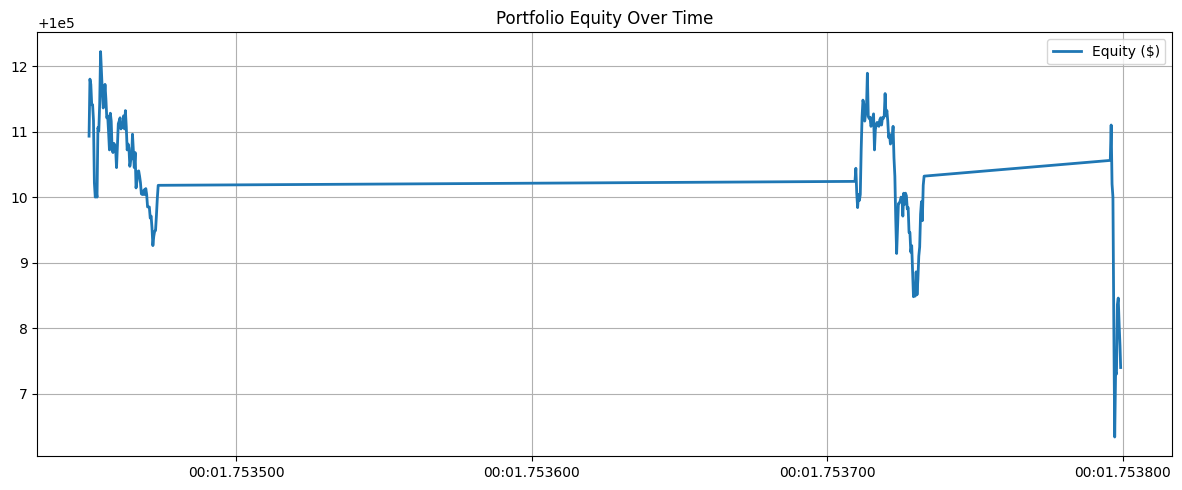

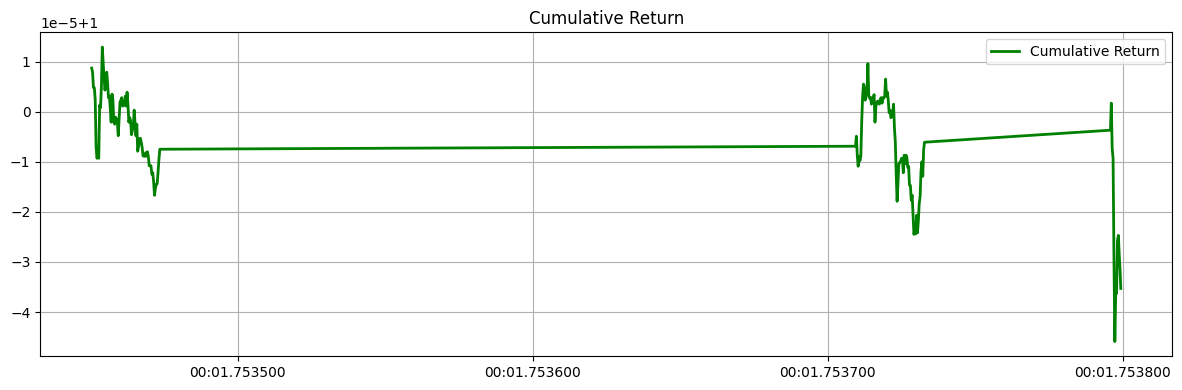


📊 Trade Summary:
ABT: {'Initial_Buy': 1}


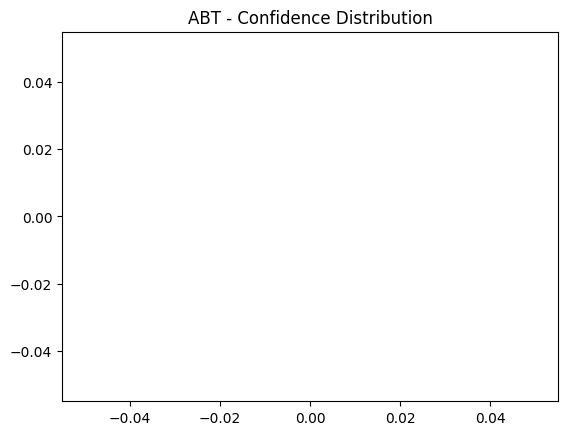

BRK.B: {'Initial_Buy': 1}


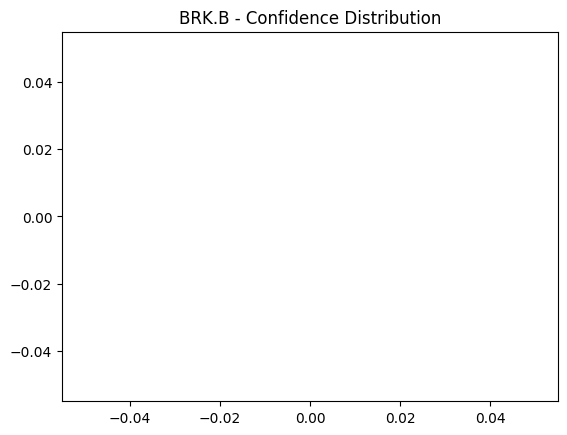

PM: {'Initial_Buy': 1}


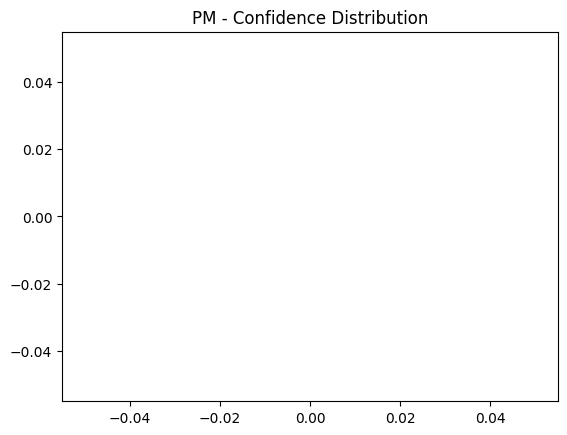

PG: {'Initial_Buy': 1}


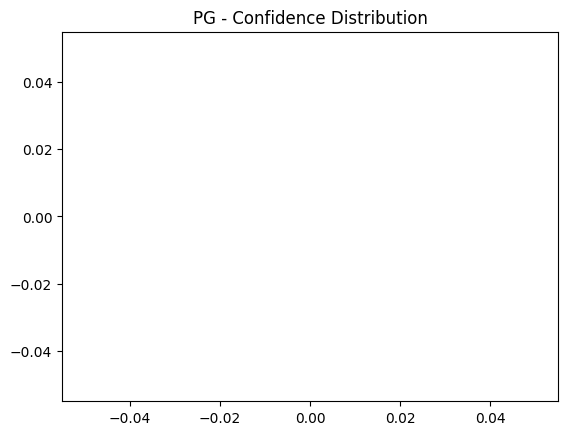

MDT: {'Initial_Buy': 1}


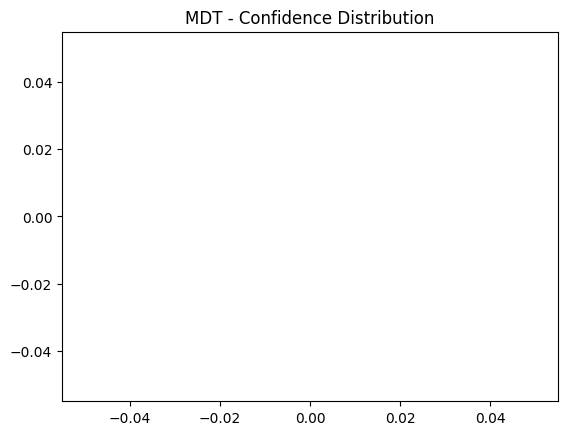

In [ ]:
# === Plot Equity / Returns ===
try:
    hist = api.get_portfolio_history(period="5D", timeframe="5Min")
    equity_series = pd.Series(hist.equity, index=pd.to_datetime(hist.timestamp))
    returns = equity_series.pct_change().dropna()
    cumulative_return = (1 + returns).cumprod()

    plt.figure(figsize=(12, 5))
    plt.plot(equity_series, label="Equity ($)", lw=2)
    plt.title("Portfolio Equity Over Time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(cumulative_return, label="Cumulative Return", color="green", lw=2)
    plt.title("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not plot equity history:", e)

# === Trade Summary ===
print("\n📊 Trade Summary:")
for ticker in tickers:
    log_file = os.path.join(RESULTS_DIR, f"trade_log_{ticker}.csv")
    if os.path.exists(log_file):
        df = pd.read_csv(log_file, on_bad_lines='skip')
        print(f"{ticker}: {df['action'].value_counts().to_dict()}")
        try:
            import seaborn as sns
            sns.histplot(df['confidence'].dropna(), bins=10)
            plt.title(f"{ticker} - Confidence Distribution")
            plt.show()
        except:
            print(f"No confidence plot for {ticker}")


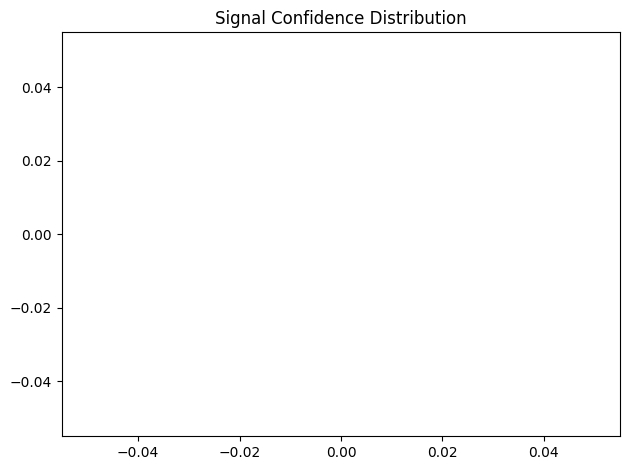


Position Summary:
  AAPL: 2 shares @ $212.77 | Value: $425.54
  ABT: 1 shares @ $127.41 | Value: $127.41
  BRK.B: 1 shares @ $484.13 | Value: $484.13
  MDT: 1 shares @ $92.30 | Value: $92.30
  PG: 1 shares @ $157.27 | Value: $157.27
  PM: 1 shares @ $159.02 | Value: $159.02

Total Market Value: $1,445.67


In [ ]:
# === Summary of Positions ===
try:
    positions = api.list_positions()
    total_market_value = 0.0
    print("\nPosition Summary:")
    for p in positions:
        mv = float(p.market_value)
        total_market_value += mv
        print(f"  {p.symbol}: {p.qty} shares @ ${float(p.current_price):.2f} | Value: ${mv:,.2f}")
    print(f"\nTotal Market Value: ${total_market_value:,.2f}")
except Exception as e:
    print(f"Could not summarize positions: {e}")